# Compress the size of an image file by using only k colors while keeping the forms

Using k-means clustering between the colors in all the pixels.  For an `m X n` RGB  image, the colors (3-vectors) are specified at each pixel, meaning that `3mn` values need to be stored.  Here, we find `k` centroid-colors using k-means clustering in this space of colors that will serve as the only colors we use. 

At each pixel, now we just need to specify which centroid-color we will map that pixel to.  The storage required for the image is just $mn + 3k$ now. Since $mn >> k$, the compression ratio will be approximately 3.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import copy

In [2]:
def k_means_clustering(img, k, max_iter, convergence_criterion, show_progress=False):
    (m, n, numchannels) = img.shape
    print('Original image needs {} floats to be stored'.format(m*n*numchannels))
    print('Final image needs {} floats to be stored'.format(m*n + k*numchannels))
    print('compression ratio is  {:4.3f}X'.format( m*n*numchannels/(m*n + k*numchannels)  ))
    
#     centroid_idx = (m*n*np.random.rand(1,k)).astype(int)
    centroid_idx = np.random.choice([i for i in range(m*n)],k)
    centroid_idx = centroid_idx.reshape(-1,1)

    row = centroid_idx // n
    column = centroid_idx % n

    centroids= np.zeros([k,numchannels])
    for c in range(k):
        x  = img[int( row[c] )][int( column[c] )] 
        centroids[c] = x

    iternum = change = 0
    chosencent = (np.zeros([m,n])).astype(int)
    old_centroids = centroids
    change = math.inf
    
    # now iterate until centroids converge
    while (iternum < max_iter) and ( change > convergence_criterion): 
            # find closest centroids
        if show_progress:
            print( 'iteration number: {}, change in centroids = {}'.format(iternum, change) )
        for i in range(m):
            for j in range(n):
                distances = []
                thispoint = img[i,j,:]
                for c in range(k): #loop over centroids                
                    # compute 2-norm distance between thispoint and cent
                    dist = np.linalg.norm(old_centroids[c]-thispoint) 
                    distances.append(dist)

                chosencent[i][j] = np.argmin(distances) # chosen for the pixel


        new_centroids = np.zeros([k,numchannels])
        for c in range(k):
            new_centroid =  np.zeros([1, numchannels])
            popul = 0
            for i in range(m):
                for j in range(n):
                    if chosencent[i][j]==c:
                        new_centroid += img[i][j]
                        popul += 1
            new_centroids[c] = new_centroid.astype(float) / popul

        change = np.linalg.norm( old_centroids - new_centroids, 'fro') #how much has one iteration changed the centroids 
        old_centroids = new_centroids
        iternum += 1
    
    new_centroids = new_centroids.astype(int)
    
    # now, assign each pixel to the closest new_centroid (the final ones)
    output_img = copy.copy(img)
    for i in range(m):
            for j in range(n):
                output_img[i,j,:] = new_centroids[ chosencent[i][j] ]
                
    return output_img

In [3]:
def plot_original_and_compressed( filename, k, max_iter, convergence_criterion, show_progress=False ):
    img=mpimg.imread(filename)
    output_img = k_means_clustering(img, k, max_iter, convergence_criterion, show_progress=show_progress)
    fig = plt.figure(num=None, figsize=(26, 12), dpi=80, facecolor='w', edgecolor='k')
    fig.canvas.set_window_title('Window Title')

    ax1 = fig.add_subplot(121) 
    ax1.set_title('Original', fontsize=18)
    ax1.imshow(img)

    ax2 = fig.add_subplot(122)
    ax2.set_title('Compressed', fontsize=18)
    ax2.imshow(output_img)

    fig.suptitle('number of colors = {}'.format(k), fontsize=20 )

## 5 colors

Original image needs 1620000 floats to be stored
Final image needs 540015 floats to be stored
compression ratio is  3.000X


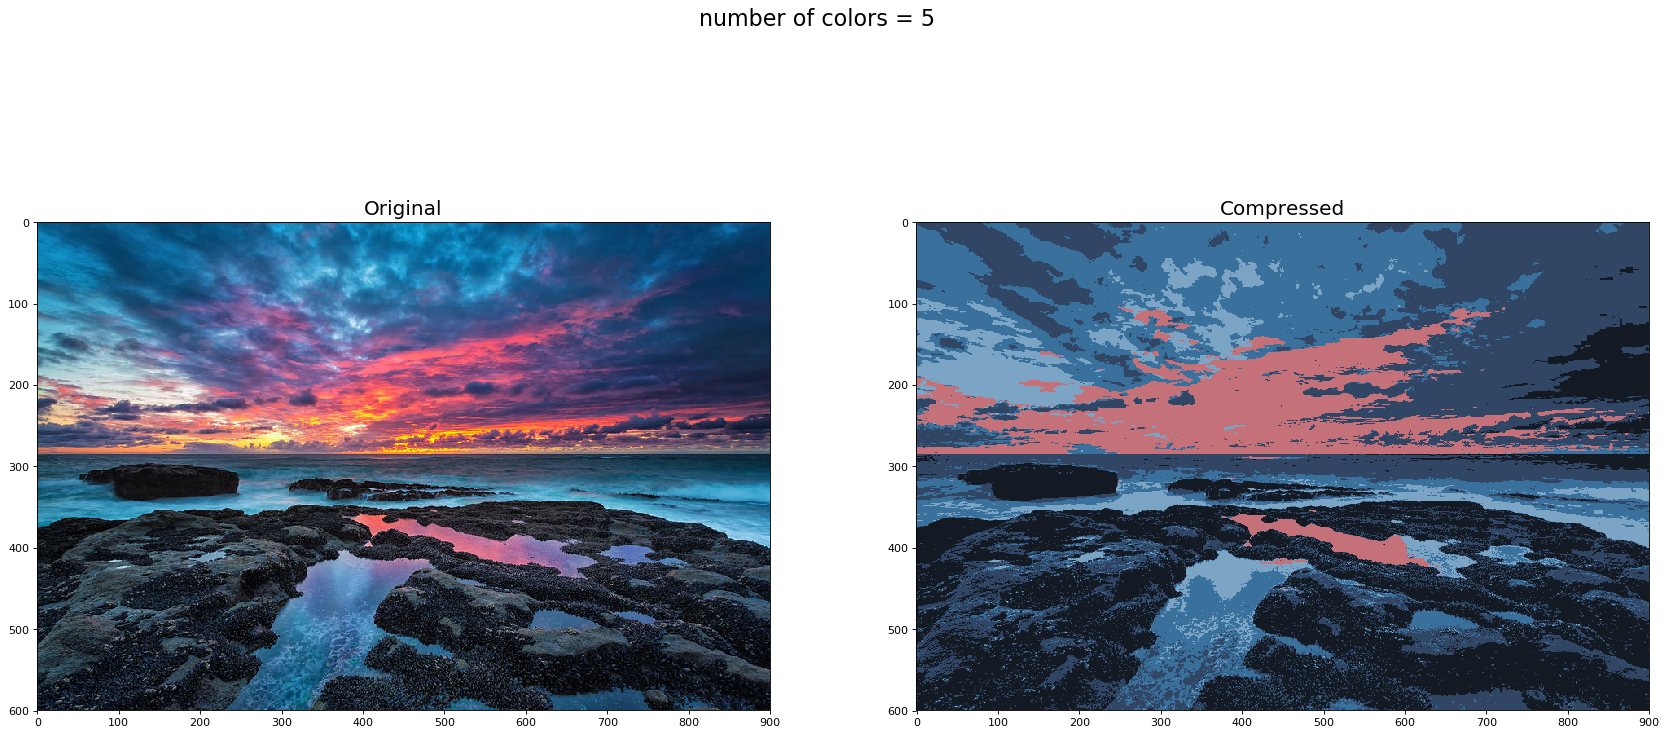

In [4]:
filename='data/Serene-Sunset.jpg'
k, max_iter, convergence_criterion = 5, 5, 1.0
plot_original_and_compressed( filename, k, max_iter, convergence_criterion)

## 15 colors

Original image needs 1620000 floats to be stored
Final image needs 540045 floats to be stored
compression ratio is  3.000X


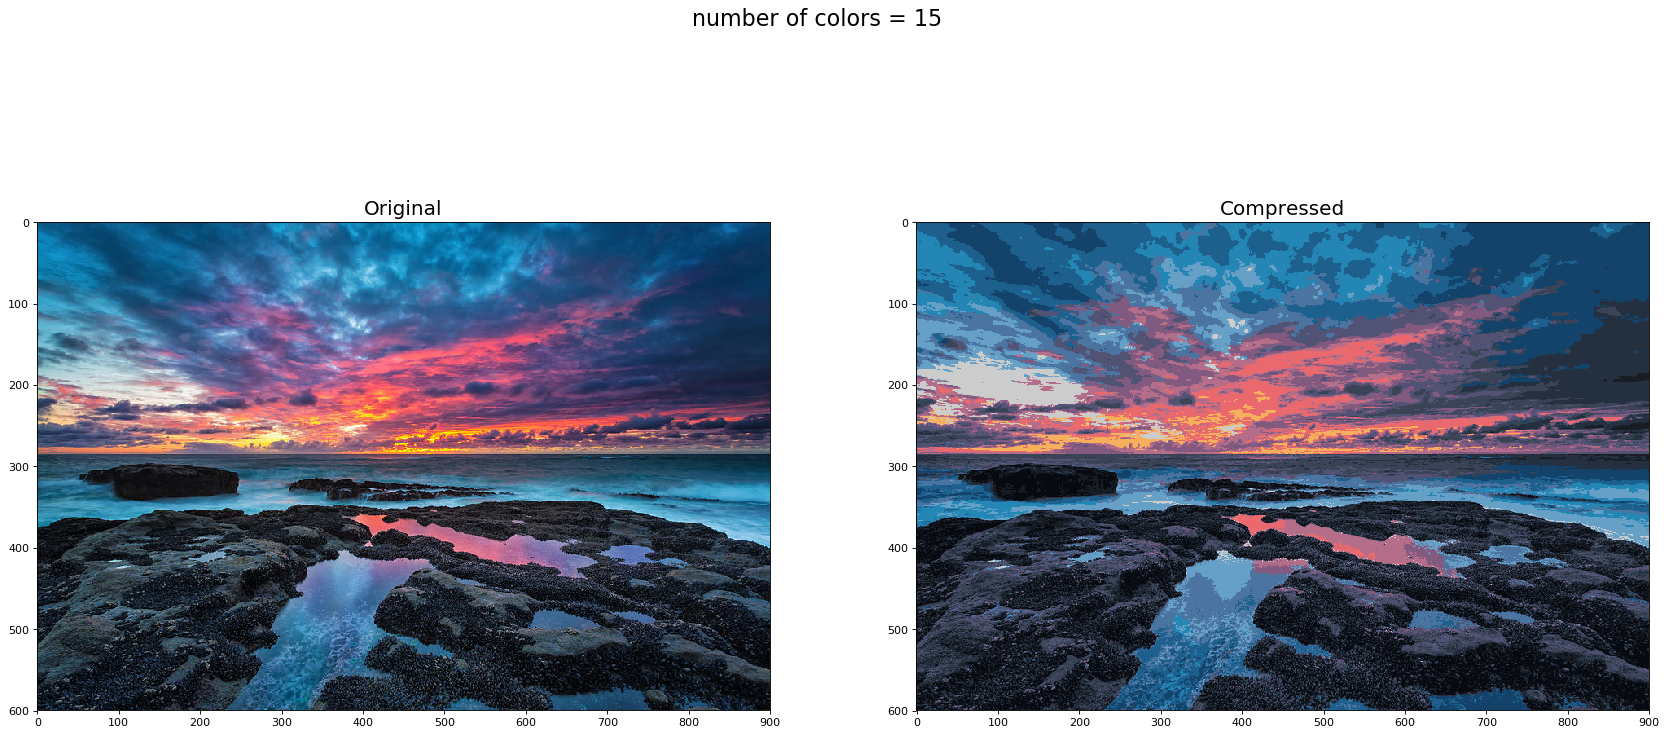

In [5]:
filename='data/Serene-Sunset.jpg'
k, max_iter, convergence_criterion = 15, 30, 1.0
plot_original_and_compressed( filename, k, max_iter, convergence_criterion)

Original image needs 1620000 floats to be stored
Final image needs 540045 floats to be stored
compression ratio is  3.000X


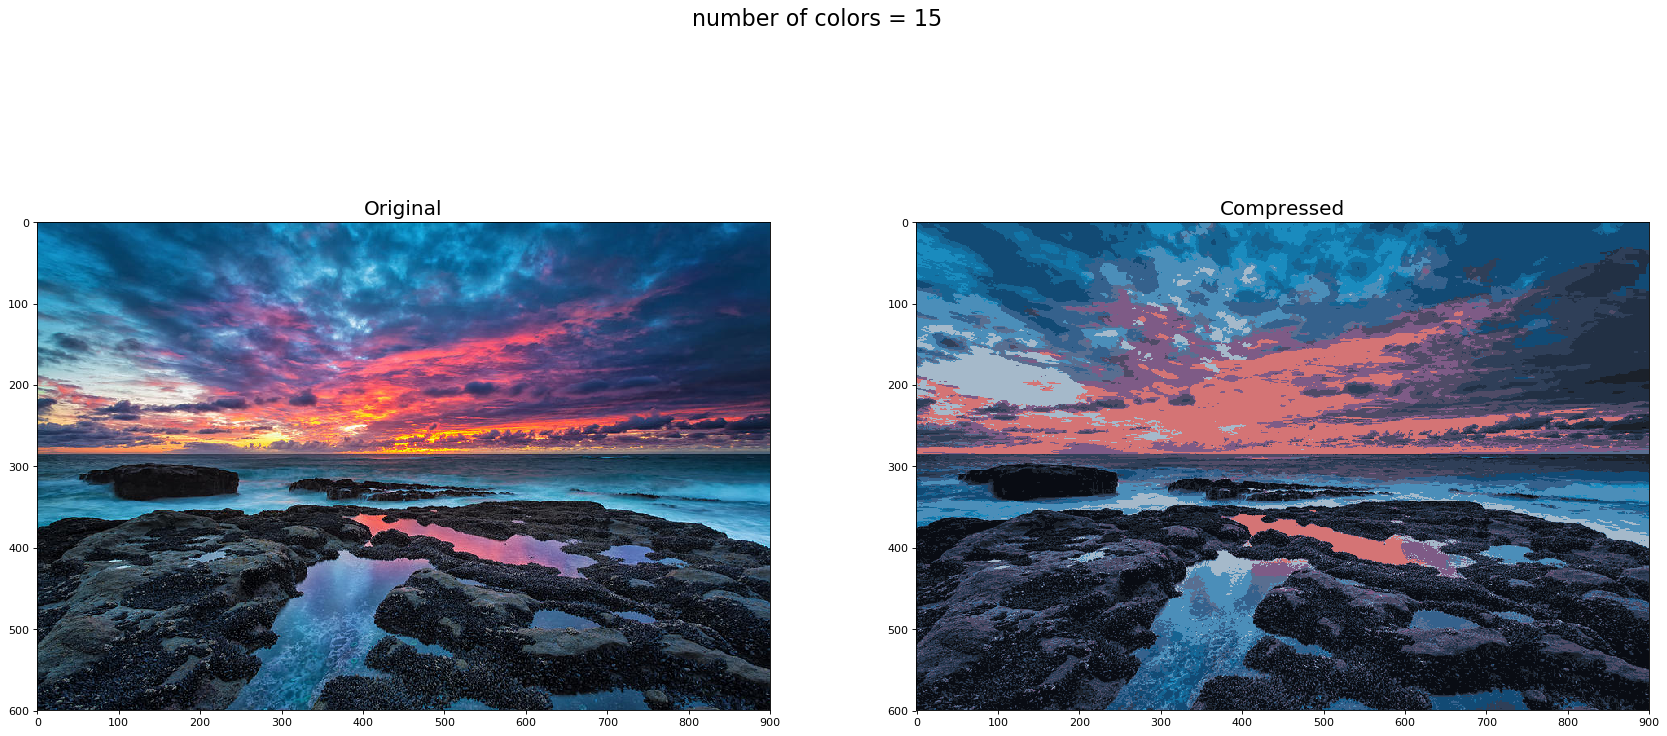

In [8]:
# many colors, but just 3 iterations  - compare with 30 iterations above
filename='data/Serene-Sunset.jpg'
k, max_iter, convergence_criterion = 15, 3, 1.0
plot_original_and_compressed( filename, k, max_iter, convergence_criterion)

Original image needs 978600 floats to be stored
Final image needs 326245 floats to be stored
compression ratio is  3.000X


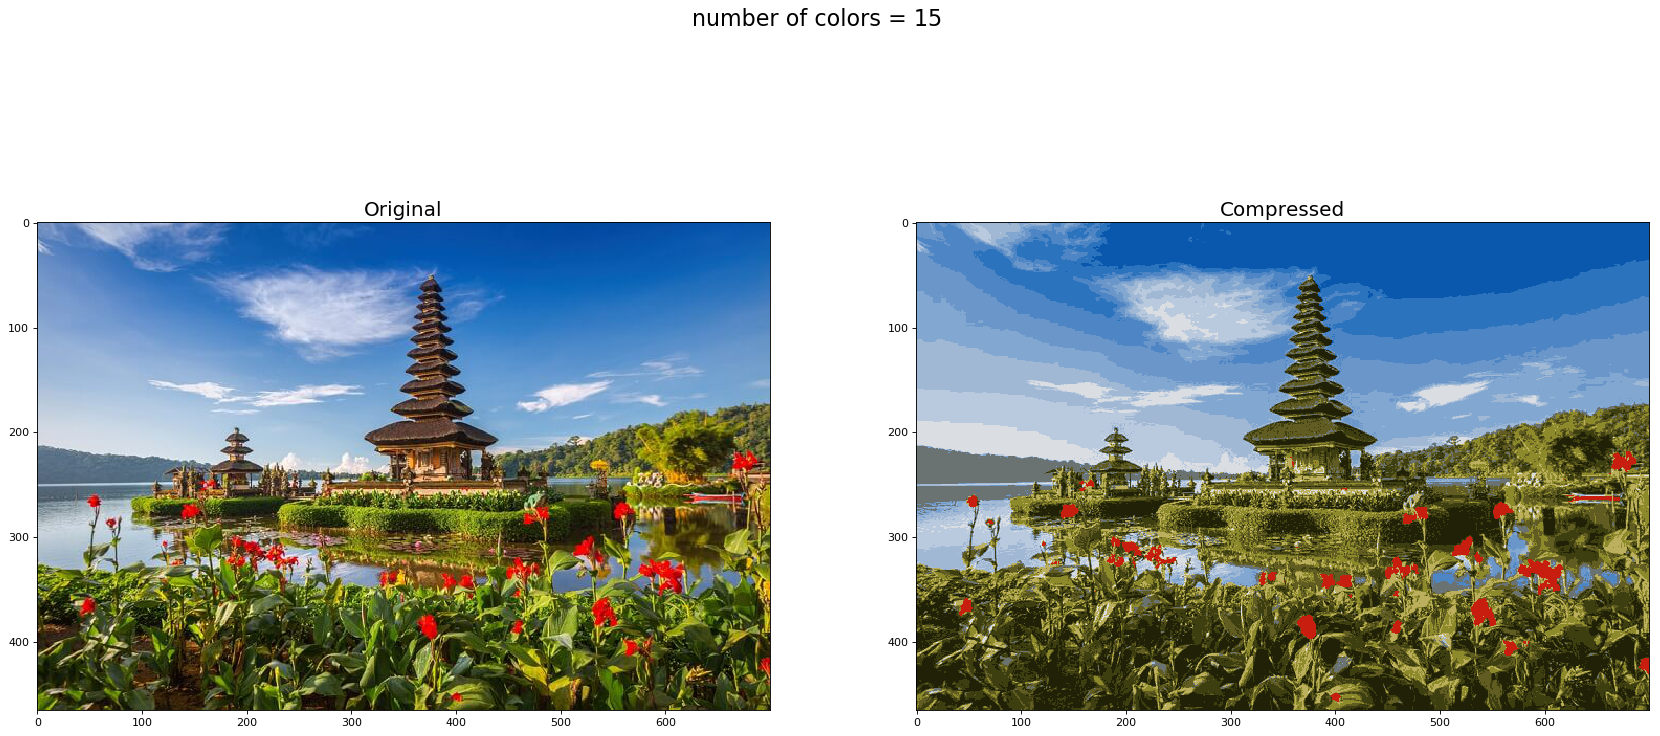

In [10]:
filename='data/Ulun-Danu.jpg'
k, max_iter, convergence_criterion = 15, 30, 1.0
plot_original_and_compressed( filename, k, max_iter, convergence_criterion)

Original image needs 1430400 floats to be stored
Final image needs 476845 floats to be stored
compression ratio is  3.000X


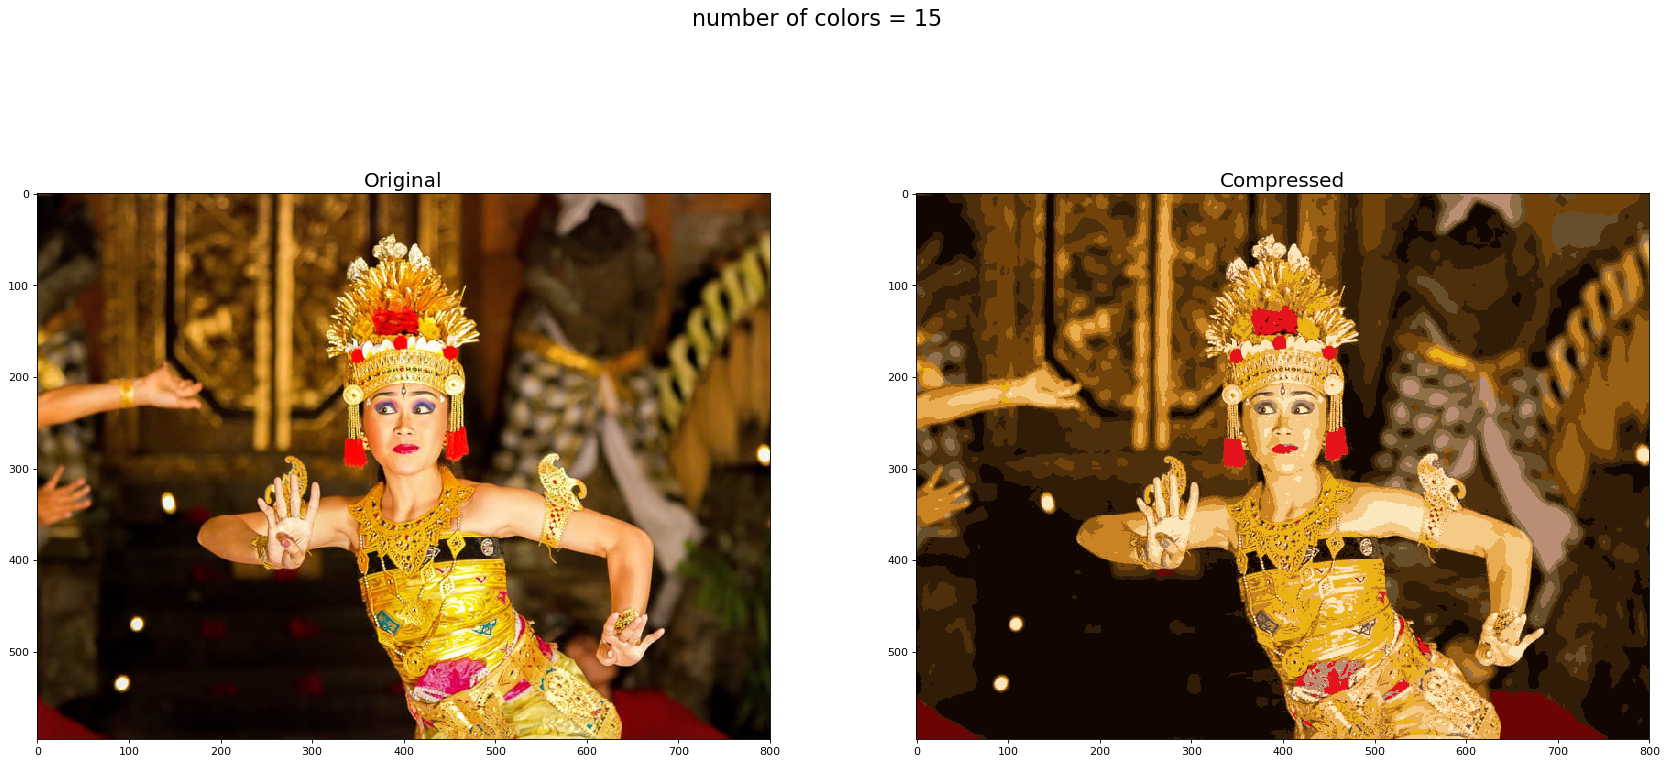

In [11]:
filename='data/Bali-Dancer.jpg'
# k, max_iter, convergence_criterion = 5, 10, 4.0
plot_original_and_compressed( filename, k, max_iter, convergence_criterion)

Original image needs 4320000 floats to be stored
Final image needs 1440045 floats to be stored
compression ratio is  3.000X


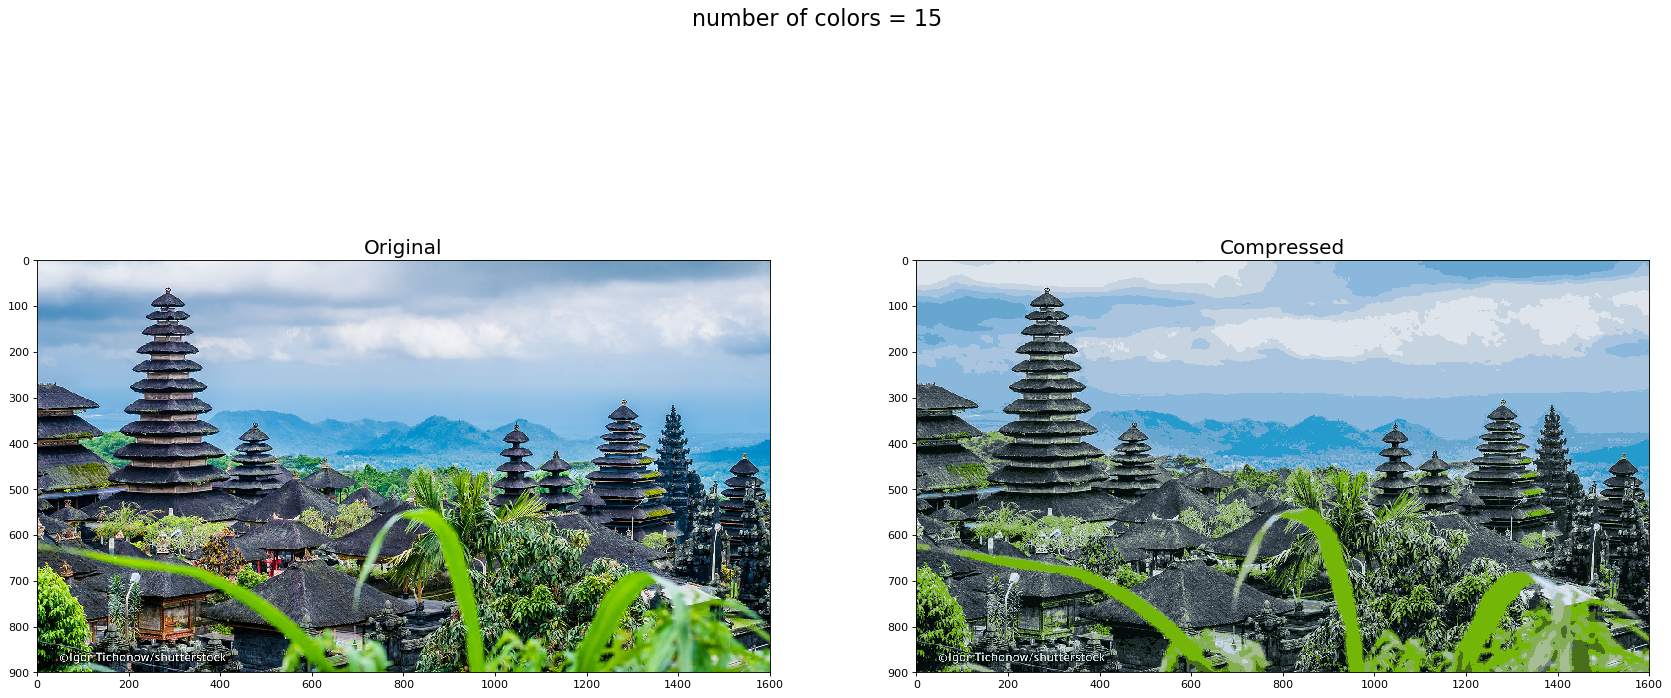

In [12]:
filename='data/Besakih.jpg'
# k, max_iter, convergence_criterion = 5, 10, 4.0
plot_original_and_compressed( filename, k, max_iter, convergence_criterion)

Original image needs 630000 floats to be stored
Final image needs 210045 floats to be stored
compression ratio is  2.999X


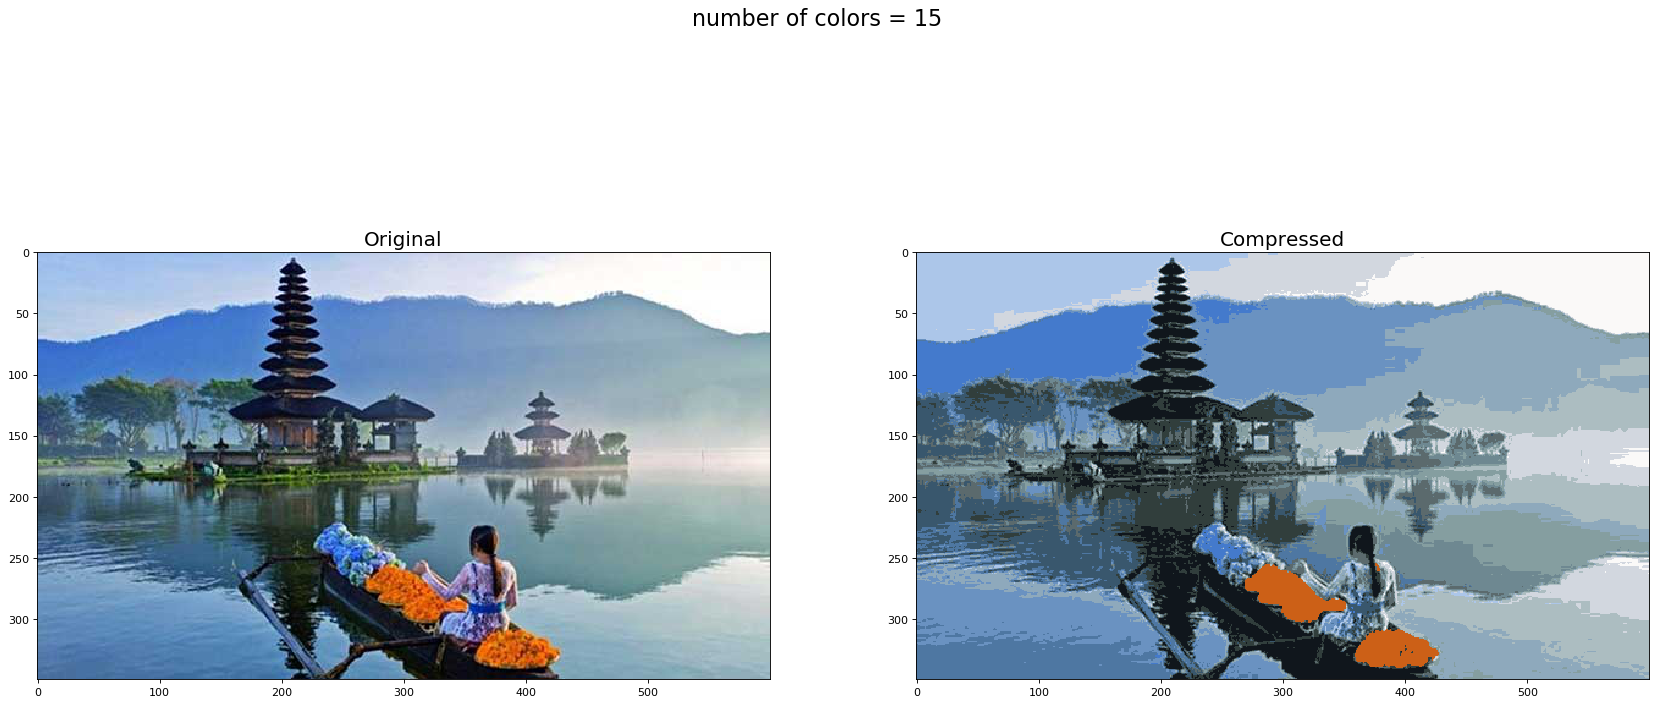

In [13]:
filename='data/Bali-temple.jpg'
# k, max_iter, convergence_criterion = 5, 10, 4.0
plot_original_and_compressed( filename, k, max_iter, convergence_criterion)

Note that this works great in images with a lot of lines and features (such as the temples, foliage above).  In images of objects such as the sky where there is a gradient of colors, the compression, being forced to pick just a few colors, has to introduce monochromatic bands which are a give-away artifact when viewed by the human eye.